In [1]:
import tensorflow as tf
from tensorflow.keras import layers

In [22]:
tf.__version__

'2.4.0'

In [115]:
r_net = slim.nets.resnet_v2.resnet_v2_101(tf.ones((1, 224, 224, 3)))

/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


# Analysis DeepLab V3+ Network

In [36]:
net = tf.keras.applications.ResNet50()

102973440/102967424 [==============================] - 3s 0us/step


In [37]:
net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

DeepLab에서 제안하는 구조에서 out stride 개념이 존재.

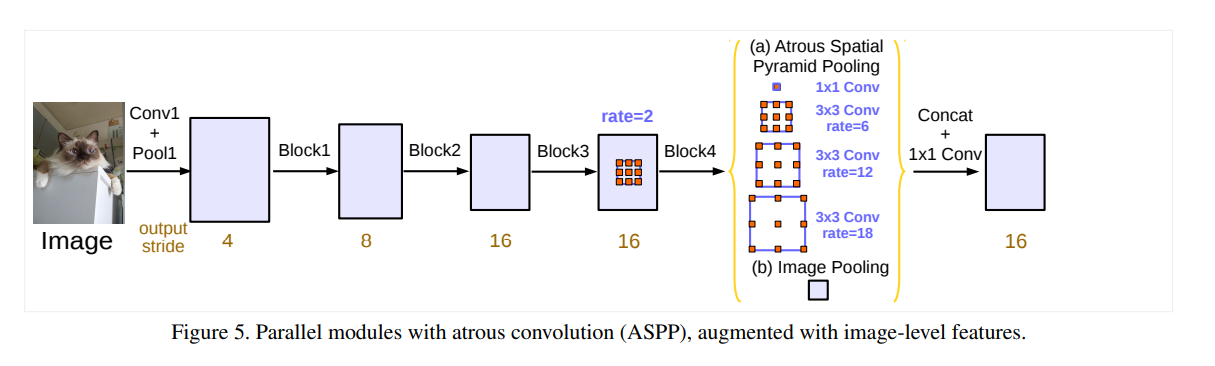

이 때, stride 8과 16의 이미지 크기가 다른 것을 알 수 있음.

stride는 pre-trained backbone network에서 가져올 이미지의 크기를 뜻함.

ex) stride 8 -> 입력 이미지의 1/8 크기, stride 16 -> 입력 이미지의 1/16 크기

만약 stride가 8이라면, 28x28 크기의 feature map을 사용한 것이며, 16이라면 14x14 크기의 feature map을 사용한 것.

실제 network의 stride 8, 16의 출력 크기는 아래와 같음.





이러한 출력을 입력으로써, Atrous Spatial Pyramid Pooling을 수행한 것이 DeepLab의 구조.


위 분석을 기반으로 하여, 실제 DeepLab V3+를 구현해보도록 하겠습니다.

# Define DeepLab V3+ Network

1. pre-trained resnet50, resnet101에서 output stride에 맞추어 layer를 가져오는 작업 수행.
2. ASPP 연산을 수행하는 함수를 정의.
3. backbone network ~ ASPP ~ Up-sampling 연산을 이어줌.

In [85]:
class conv_bn_act(tf.keras.layers.Layer):
    def __init__(self, filters, k_s, s_t, rate):
        super(conv_bn_act, self).__init__()
        self.conv = layers.Conv2D(filters, k_s, s_t, dilation_rate=rate, padding='same')
        self.bn = layers.BatchNormalization()
        self.act = layers.ReLU()
        
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        
        return x

In [110]:
class ASPP(tf.keras.layers.Layer):
    def __init__(self, output_stride, depth=256):
        super(ASPP, self).__init__()
        dilation_rate = [6, 12, 18]
        
        if output_stride == 8:
            dilation_rate = [2*rate for rate in dilation_rate]
            input_size = 28
        else:
            input_size = 14
            
        # 1x1 convolution
        self.conv_1x1 = conv_bn_act(depth, 1, 1, 1)
        
        # 3x3 convolution
        self.conv_3x3_1 = conv_bn_act(depth, 3, 1, dilation_rate[0])
        self.conv_3x3_2 = conv_bn_act(depth, 3, 1, dilation_rate[1])
        self.conv_3x3_3 = conv_bn_act(depth, 3, 1, dilation_rate[2])
        
        # image-level feature, interpolation: A string, one of `nearest` or `bilinear`
        self.image_pooling = layers.GlobalAveragePooling2D()
        self.image_conv = conv_bn_act(depth, 1, 1, 1)
        self.interpolation = layers.UpSampling2D(size=(input_size, input_size), interpolation='bilinear') 
        
        # after concatenate convolution
        self.after_conv = conv_bn_act(depth, 1, 1, 1)
        
    def call(self, inputs):
        
        # 1x1 convolution output
        output1 = self.conv_1x1(inputs)
        
        # 3x3 convolution outputs
        output2 = self.conv_3x3_1(inputs)
        output3 = self.conv_3x3_2(inputs)
        output4 = self.conv_3x3_3(inputs)
        
        # image-level feature
        output5 = self.image_pooling(inputs)
        output5 = self.image_conv(tf.reshape(output5, (-1, 1, 1, output5.shape[-1])))
        output5 = self.interpolation(output5)
        
        # concatenate & 1x1 convolution output
        concat = layers.concatenate([output1, output2, output3, output4, output5], axis=-1)
        output = self.after_conv(concat)
        
        return output

In [132]:
class DeepLabV3plus(tf.keras.Model):
    def __init__(self, base_network, output_stride, num_class):
        super(DeepLabV3plus, self).__init__()
        # backbone network output -> 256 or 512 channels
        if base_network == 'resnet50':
            self.pre_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
            if output_stride == 8:
                self.base_model = tf.keras.models.Model(inputs=self.pre_model.input,
                                                        outputs=self.pre_model.get_layer(name='conv3_block4_out').output)
            else:
                self.base_model = tf.keras.models.Model(inputs=self.pre_model.input,
                                                        outputs=self.pre_model.get_layer(name='conv4_block6_out').output)
        else:
            self.pre_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
            if output_stride == 8:
                self.base_model = tf.keras.models.Model(inputs=self.pre_model.input,
                                                        outputs=self.pre_model.get_layer(name='conv3_block4_out').output)
            else:
                self.base_model = tf.keras.models.Model(inputs=self.pre_model.input,
                                                        outputs=self.pre_model.get_layer(name='conv4_block23_out').output)
        # low-level output
        self.low_output = tf.keras.models.Model(inputs=self.pre_model.input,
                                                outputs=self.pre_model.get_layer(name='conv2_block3_out').output)
            
        del self.pre_model
        self.base_model.trainable = False
                
        # Atrous Spatial Pyramid Pooling
        self.aspp = ASPP(output_stride)
        
        # Up-sampling ASPP outputs 
        if output_stride == 8:
            self.up_sample1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
        else:
            self.up_sample1 = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')
            
        # after concatenate low level feature
        self.conv_1x1 = conv_bn_act(48, 1, 1, 1)
        self.conv_3x3_1 = conv_bn_act(256, 3, 1, 1)
        self.conv_3x3_2 = conv_bn_act(256, 3, 1, 1)
        self.up_sample2 = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')
        
        # prediction layer
        self.last = layers.Conv2D(num_class, 1)
        
        
    def call(self, inputs):
        output = self.base_model(inputs)
        output = self.aspp(output)
        output = self.up_sample1(output)
        
        # first Up-sampling
        low_level_output = self.low_output(inputs)
        low_output = self.conv_1x1(low_level_output)
        output = layers.concatenate([output, low_output], axis=-1)
        
        # second Up-sampling
        output = self.conv_3x3_1(output)
        output = self.conv_3x3_2(output)
        output = self.up_sample2(output)
        
        # final output
        output = self.last(output)
        
        return output

In [141]:
net = DeepLabV3plus(base_network='resnet50', output_stride=16, num_class=21)